In [131]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [132]:
import matplotlib
import matplotlib.pyplot as plt
import glob
import math
import re
import numpy as np
#import pandas as pd
from bisect import *
from decimal import Decimal
#from scipy.optimize import curve_fit
#import scipy.special as sps

In [133]:
def parseCountsNorm(di,denName):
    do = {}
    for wf in di :
      den = 1.
      if (denName!='') : den = di[wf][denName]
      if (denName=='task-clock') : den*=1000.*1000.
      for k in di[wf] :
        ko = k
        if (k=='task-clock') :
          ko='nsec'
        if(k=='seconds') : ko='wall-clock-ns'
        if not ko in do : do[ko] = {}
        do[ko][wf] = di[wf][k]/den
        if (ko=='nsec') :  do[ko][wf]*=1000.*1000.
        if (ko=='wall-clock-ns') :  do[ko][wf]*=1000*1000.*1000.
    return do


def doPrint(di) :
  s = '|' + ' | '
  for wf  in di['cycles'] :
    s+= ' ' + wf + ' |'
  s += '|'
  print(s)
  for k in di :
    s = '|' + k + ' | '
    for wf  in di[k] :
        v = di[k][wf]
        s+= ' ' + "{:6.4f}".format(v)  + ' | '
    s += '|'
    print(s)


def parseCounts(fname) :
  nop=0
  d ={}
  with open(fname) as f:
    print('\n\n---++ '+fname)
    for line in f:
      try:
        (wf, val, key) = line.split()
        d[wf] = {}
      except:
        nop+=1
  with open(fname) as f:
    for line in f:
      try:
        (wf, val, key) = line.split()
        d[wf][key]= float(val)
      except:
        nop+=1
  return d

def parseOne(fname) :
  d = parseCounts(fname)
  dr = parseCountsNorm(d,'')
  dc = parseCountsNorm(d,'cycles')
  di = parseCountsNorm(d,'instructions')
  ds = parseCountsNorm(d,'task-clock')
  return [dc,di,ds,dr]

In [134]:
dir = '/Users/innocent/cernbox/HLTperf/'
# files = [dir+"Haswell/haswell.count",dir+"Skylake/skylake.count",dir+"Icelake/icelake.count"]
files = [dir+"HLTPerfCounts",dir+"HLTPerfCountsHalfMachine",dir+"HLTPerfCountsFullMachine"]
scores={}
scores['HLT']=parseOne(files[2])
#scores['HLT'][3]



---++ /Users/innocent/cernbox/HLTperf/HLTPerfCountsFullMachine


In [135]:
norNames = ['cycles','instructions','task-clock','']
theONE= 'HLT'
di = scores[theONE][0]['cycles']
labels = []
for wf in di : labels.append(wf)
print(labels)
for wf in labels :
        if re.search("Milan",wf) : print(wf)


['FullMachine1000_MilanSEE', 'FullMachine2000_MilanSEE', 'FullMachine4000_MilanSEE', 'FullMachine400_MilanSEE', 'FullMachine8000_MilanSEE', 'FullMachineIdle_Milan']
FullMachine1000_MilanSEE
FullMachine2000_MilanSEE
FullMachine4000_MilanSEE
FullMachine400_MilanSEE
FullMachine8000_MilanSEE
FullMachineIdle_Milan


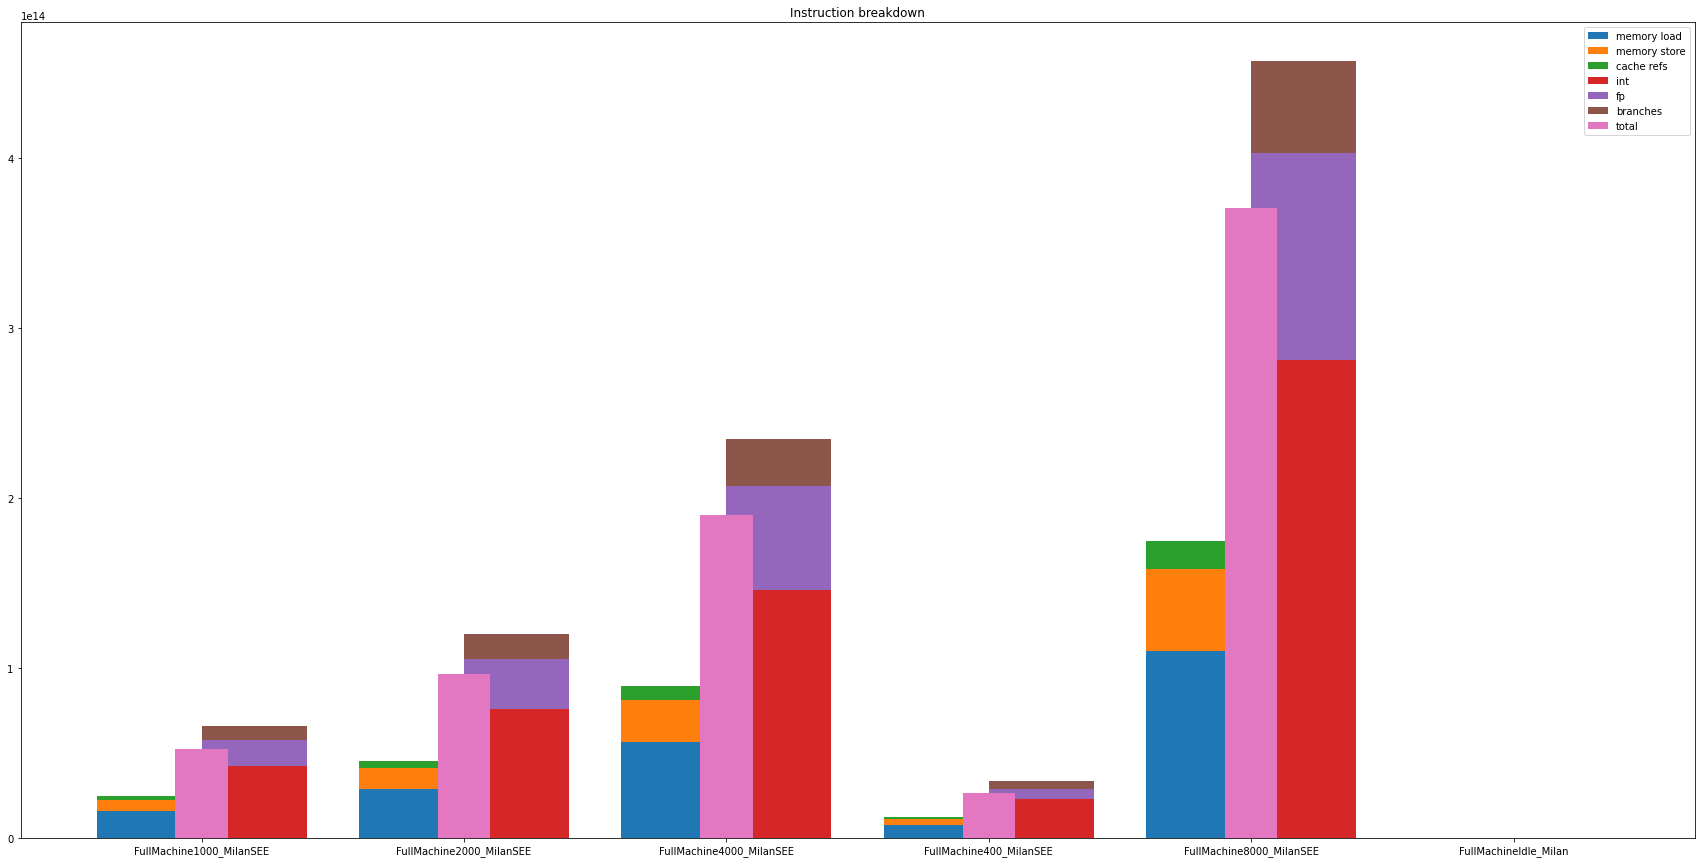

In [136]:
def doSum(vars,nor,code) :
    di = scores[theONE][nor]
    ret = []
    for wf in labels :
        if re.search(code,wf) :
          q = 0.
          for var in vars : q += di[var][wf]
          ret.append(q)
    return ret
def instrBD() :
    code = "Milan"
    plt.rcParams["figure.figsize"] = (30,15)
    tot = ['instructions']
    load = ['ls_dispatch.ld_dispatch']
    store = ['ls_dispatch.store_dispatch']
    ref = ['cache-references']
    fp = ['ex_ret_mmx_fp_instr.sse_instr']
    br = ['branch-instructions']
    intop = ['de_dis_cops_from_decoder.disp_op_type.any_integer_dispatch']
    fpop = ['de_dis_cops_from_decoder.disp_op_type.any_fp_dispatch']
    ll = []
    for wf in labels :
        if re.search(code,wf) : ll.append(wf)
            
    x = np.arange(len(ll))  # the label locations
    width = 0.4  # the width of a bar
    
    fig, ax = plt.subplots()
    rects0 = ax.bar(x - width/2, doSum(load,3,code), width, label='memory load')
    all = load
    rects1 = ax.bar(x - width/2, doSum(store,3,code), width, label='memory store',bottom=doSum(all,3,code))
    all += store
    rects2 = ax.bar(x - width/2, doSum(ref,3,code), width, label='cache refs',bottom=doSum(all,3,code))
    all += ref
    #rects3 = ax.bar(x - width/2, doSum(br,3,code), width, label='branches',bottom=doSum(all,3,code))
    #all += br
    #rects4 = ax.bar(x - width/2, doSum(fp,3,code), width, label='fp',bottom=doSum(all,3,code))
    #
    rectsA = ax.bar(x + width/2, doSum(intop,3,code), width, label='int')
    all = intop
    rectsB = ax.bar(x + width/2, doSum(fp,3,code), width, label='fp',bottom=doSum(all,3,code))
    all += fp
    rectsC = ax.bar(x + width/2, doSum(br,3,code), width, label='branches',bottom=doSum(all,3,code))
    all += br
    #rectsD = ax.bar(x + width/2, doSum(store,3), width, label='memory store',bottom=doSum(all,3))
    #all += store
    rectsQ = ax.bar(x, doSum(tot,3,code), width/2, label='total')
    

    # ax.set_ylim(0.,1.)
    ax.set_title('Instruction breakdown')
    ax.set_xticks(x,ll)
    ax.legend()
    plt.show()

instrBD()

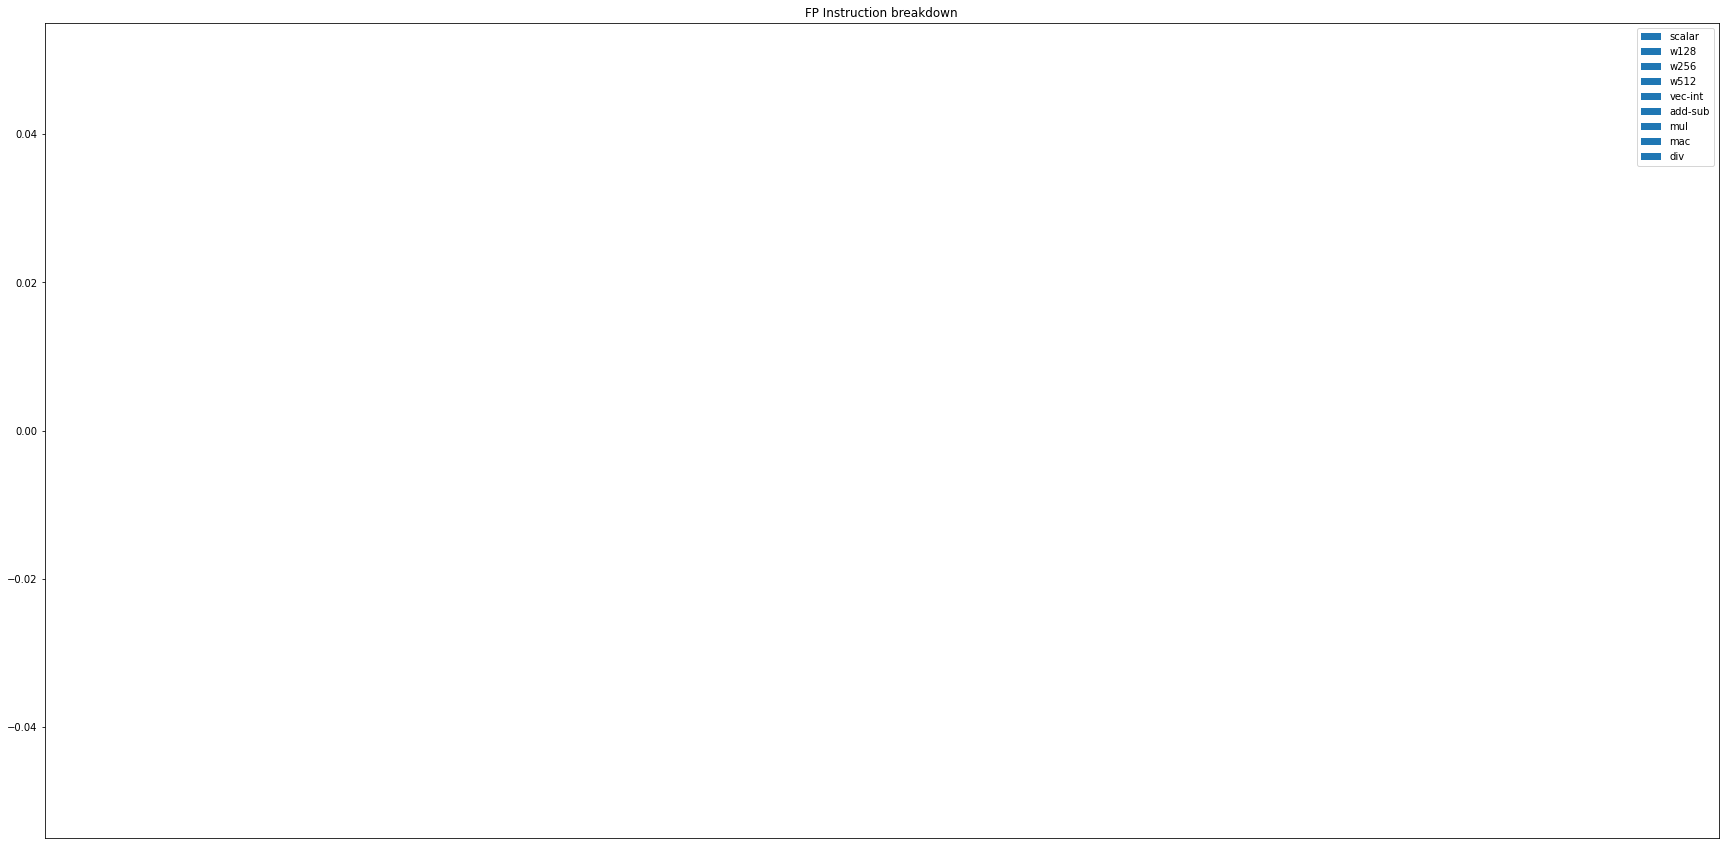

In [137]:
def instrFP() :
    code = "Genoa"
    plt.rcParams["figure.figsize"] = (30,15)
    
    tot = ['instructions']
    fp = ['fp_ops_retired_by_width.all']
    into = ['packed_int_op_type.all']
    scalar = ['fp_ops_retired_by_width.scalar_uops_retired']
    w128 = ['fp_ops_retired_by_width.pack_128_uops_retired']
    w256 = ['fp_ops_retired_by_width.pack_256_uops_retired']
    w512 = ['fp_ops_retired_by_width.pack_512_uops_retired']
    flops = ['fp_ret_sse_avx_ops.all'] 
    add = ['fp_ret_sse_avx_ops.add_sub_flops'] 
    mul = ['fp_ret_sse_avx_ops.mult_flops']
    mac = ['fp_ret_sse_avx_ops.mac_flops']
    div = ['fp_ret_sse_avx_ops.div_flops']
    
    ll = []
    for wf in labels :
        if re.search(code,wf) : ll.append(wf)
            
    x = np.arange(len(ll))  # the label locations
    width = 0.4  # the width of a bar
    
    fig, ax = plt.subplots()
    #rectsQ = ax.bar(x, doSum(tot,3,code), width/2, label='total')
    rects1 = ax.bar(x - width/2, doSum(scalar,3,code), width, label='scalar')
    all = scalar
    rects2 = ax.bar(x - width/2, doSum(w128,3,code), width, label='w128',bottom=doSum(all,3,code))
    all += w128
    rects3 = ax.bar(x - width/2, doSum(w256,3,code), width, label='w256',bottom=doSum(all,3,code))
    all += w256
    rects4 = ax.bar(x - width/2, doSum(w512,3,code), width, label='w512',bottom=doSum(all,3,code))
    all += w512
    rectsI = ax.bar(x - width/8, doSum(into,3,code), width/4, label='vec-int')
    
    #
    rectsA = ax.bar(x + width/2, doSum(add,3,code), width, label='add-sub')
    all = add
    rectsB = ax.bar(x + width/2, doSum(mul,3,code), width, label='mul',bottom=doSum(all,3,code))
    all += mul
    rectsC = ax.bar(x + width/2, doSum(mac,3,code), width, label='mac',bottom=doSum(all,3,code))
    all += mac
    rectsD = ax.bar(x + width/2, doSum(div,3,code), width, label='div',bottom=doSum(all,3,code))
    all += div
    #rectsP = ax.bar(x + width/8, doSum(flops,3,code), width/4, label='tot flops')
    #rectsI = ax.bar(x + width/8, doSum(into,3,code), width/4, label='int',bottom=doSum(flops,3,code))
   

    # ax.set_ylim(0.,1.)
    ax.set_title('FP Instruction breakdown')
    ax.set_xticks(x,ll)
    ax.legend()
    plt.show()

instrFP()

In [138]:
def plotOne(var,nor) :
    den =1 
    global iden
    norName = norNames[nor]
    plt.rcParams["figure.figsize"] = (30,10)
    lu = []
    di = scores[theONE][nor][var]
    if iden != '' : den = di[iden]
    for wf in labels : lu.append(di[wf]/den)
  
    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of a bar

    fig, ax = plt.subplots()
    rects2 = ax.bar(x - width/2, lu, width, label='HLT')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    label = var
    if (len(norName)>0) : label = var+'/'+norName
    ax.set_ylabel(label)
    ax.set_title(label)
    ax.set_xticks(x,labels)
    ax.legend()
    ax.bar_label(rects2, padding=3)


    # fig.tight_layout()

    plt.show()

def plotSum(vars,nor,title) :
    norName = norNames[nor]
    plt.rcParams["figure.figsize"] = (30,10)
    lu = []
    di = scores[theONE][nor]
    for wf in labels :
        q = 0.
        for var in vars : q += di[var][wf]
        lu.append(q)
  
    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of a bar

    fig, ax = plt.subplots()
    rects2 = ax.bar(x - width/2, lu, width, label='LU on Milan')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(title+'/'+norName)
    ax.set_title(title)
    ax.set_xticks(x,labels)
    ax.legend()
    ax.bar_label(rects2, padding=3)


    # fig.tight_layout()

    plt.show()


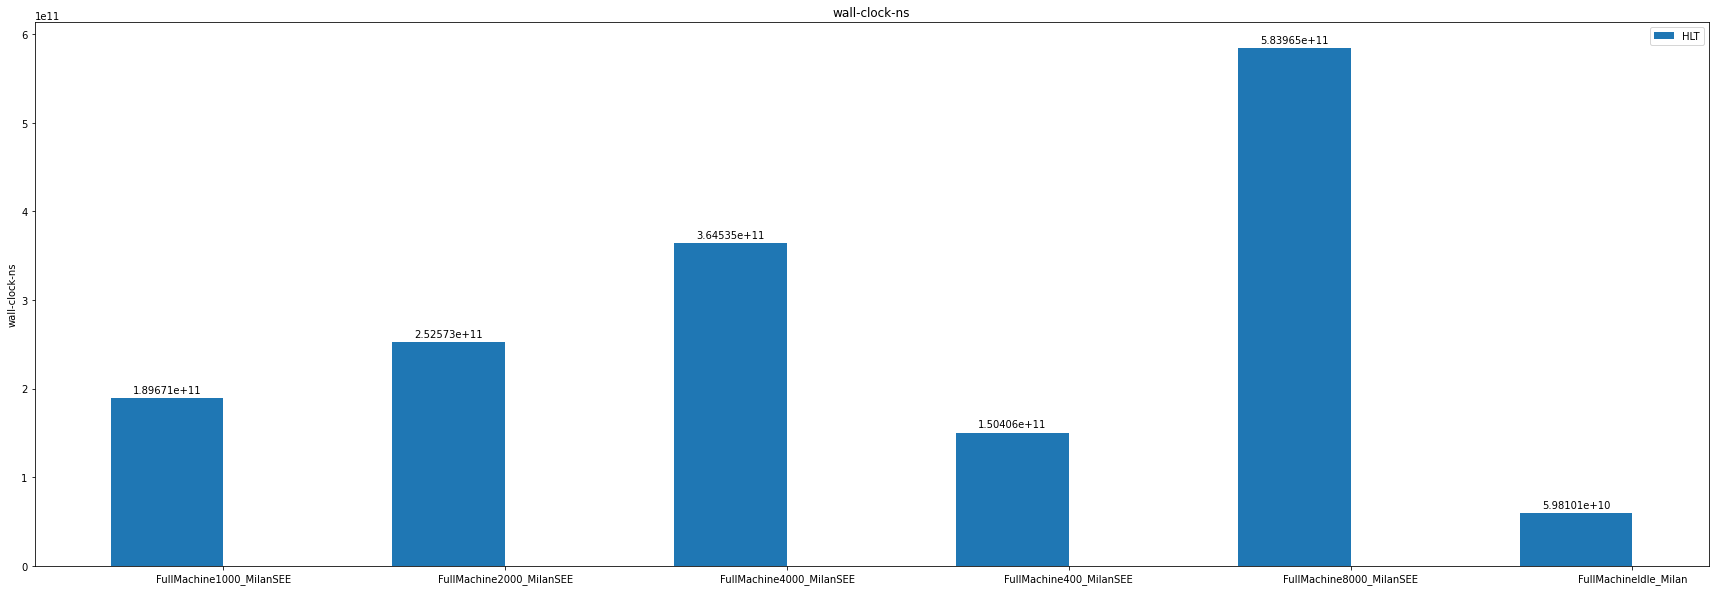

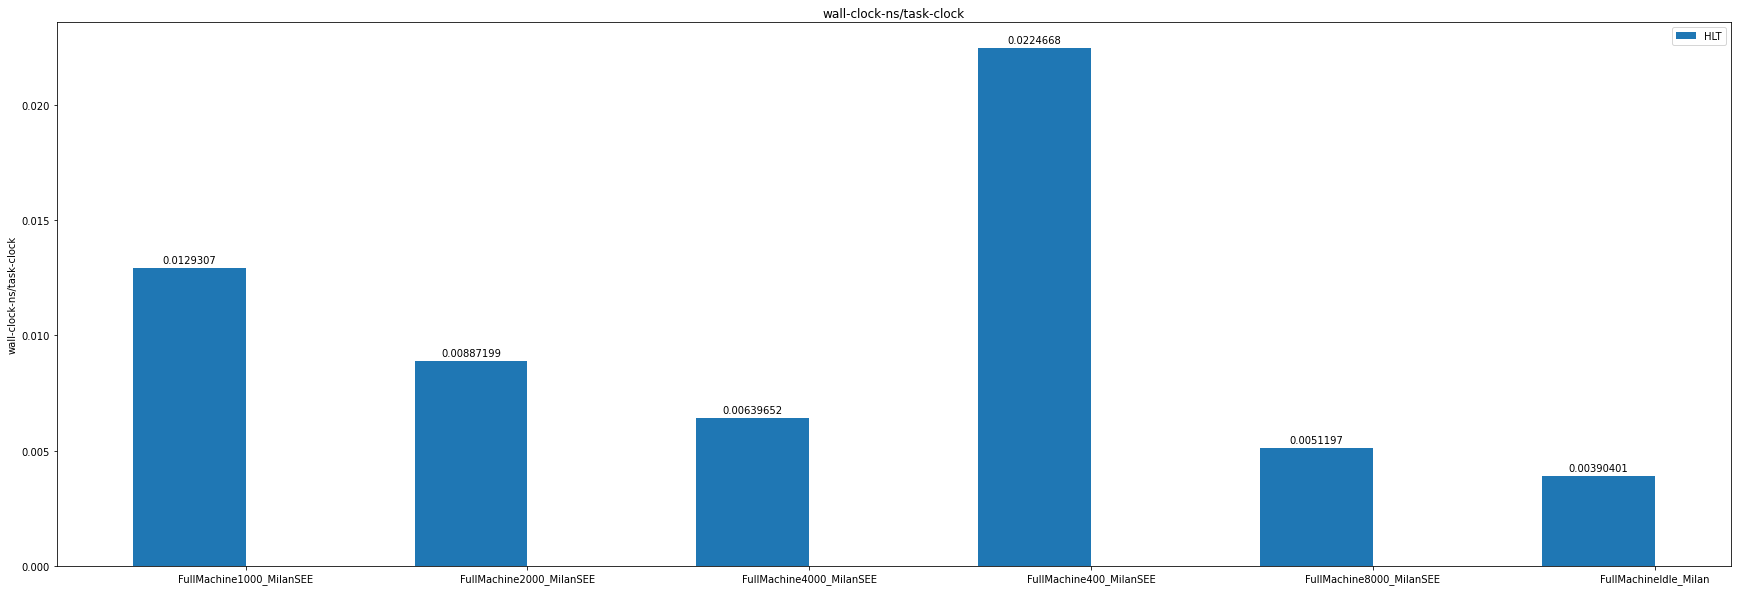

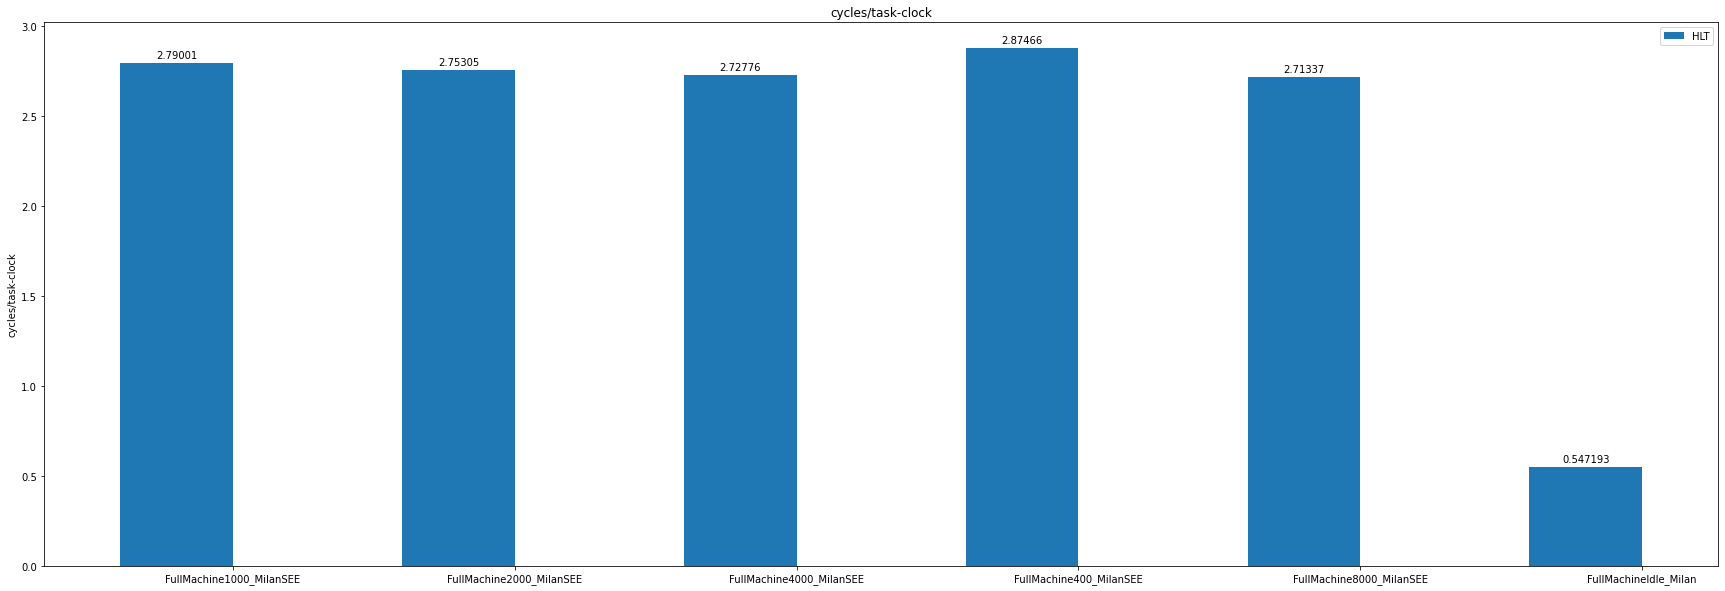

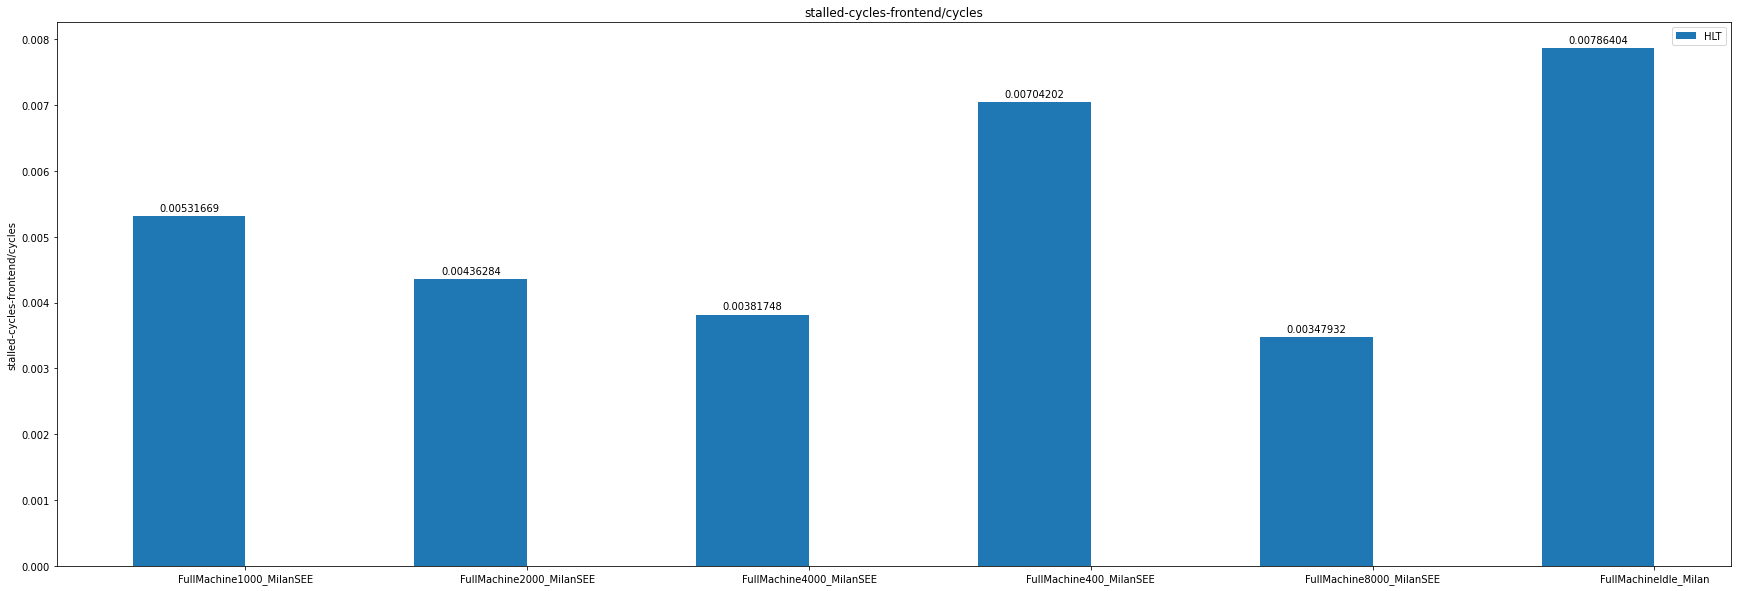

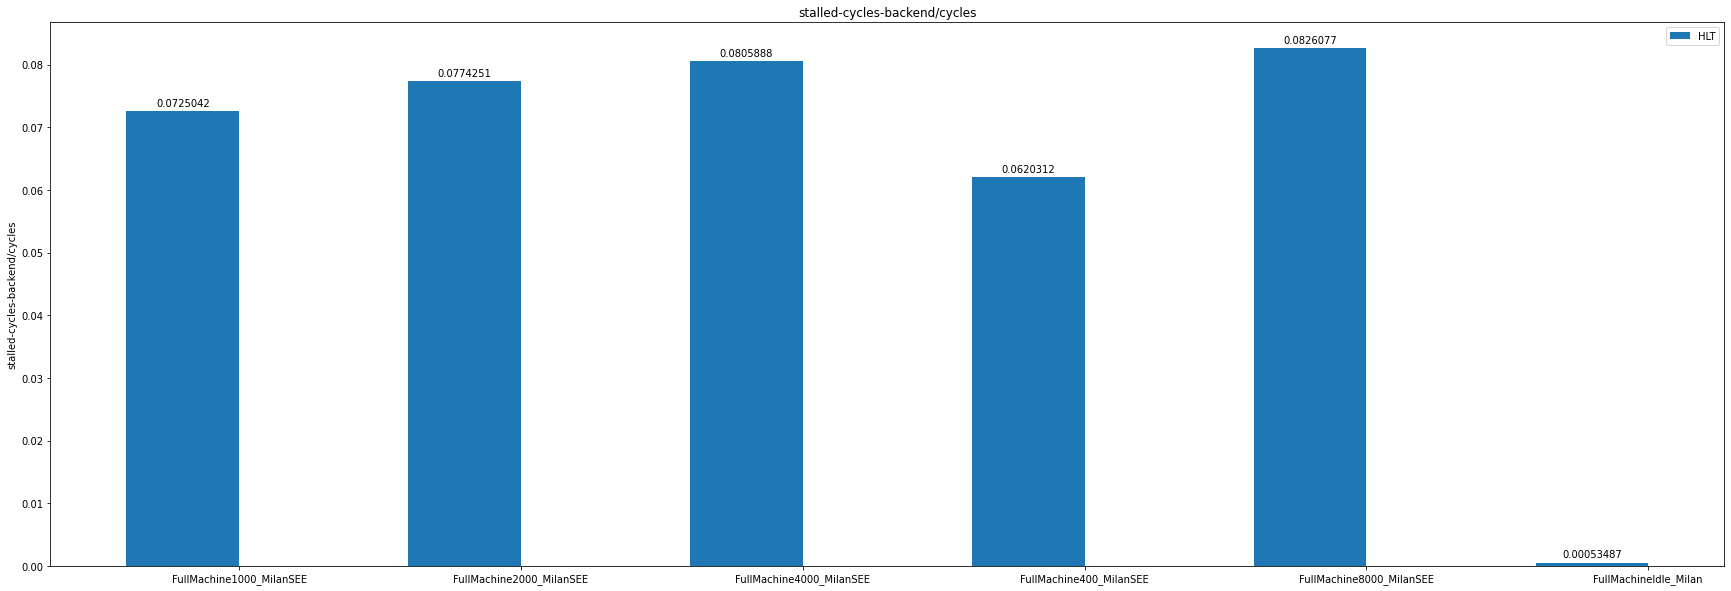

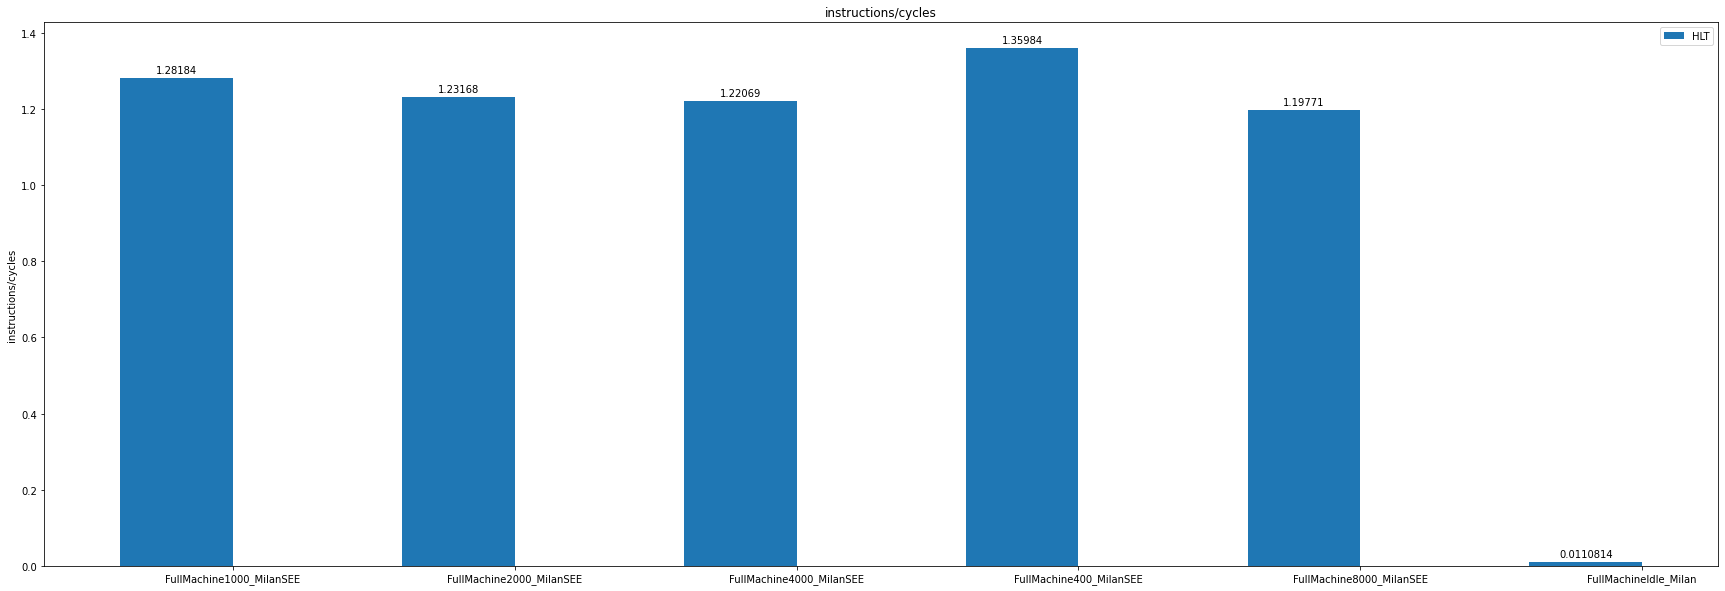

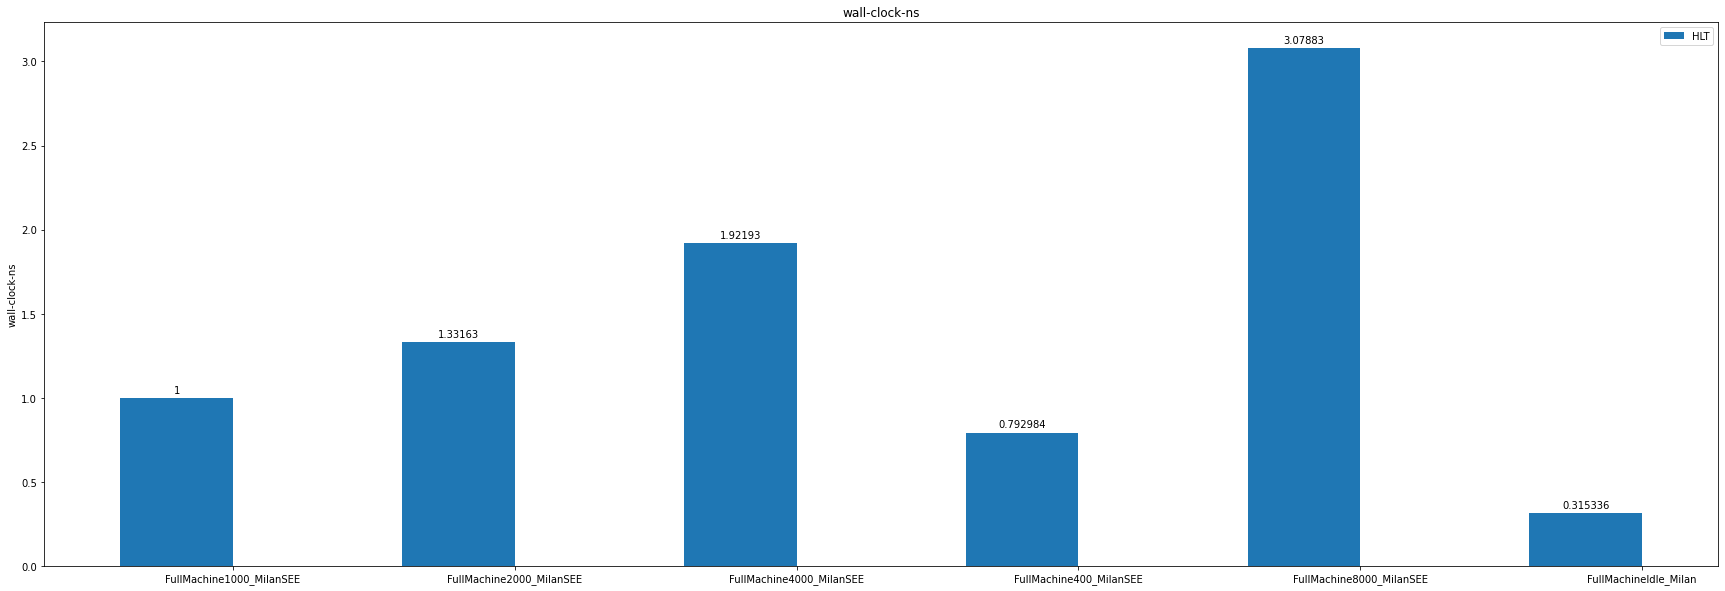

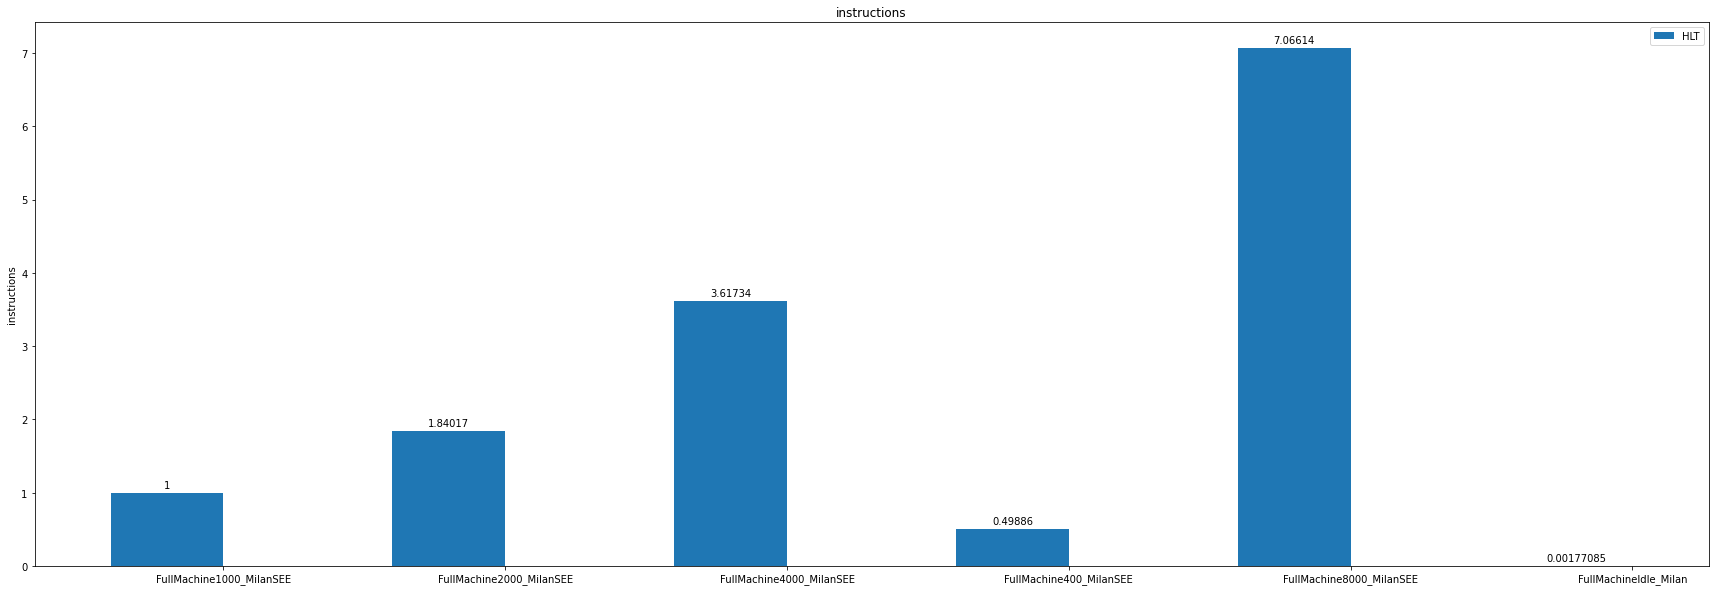

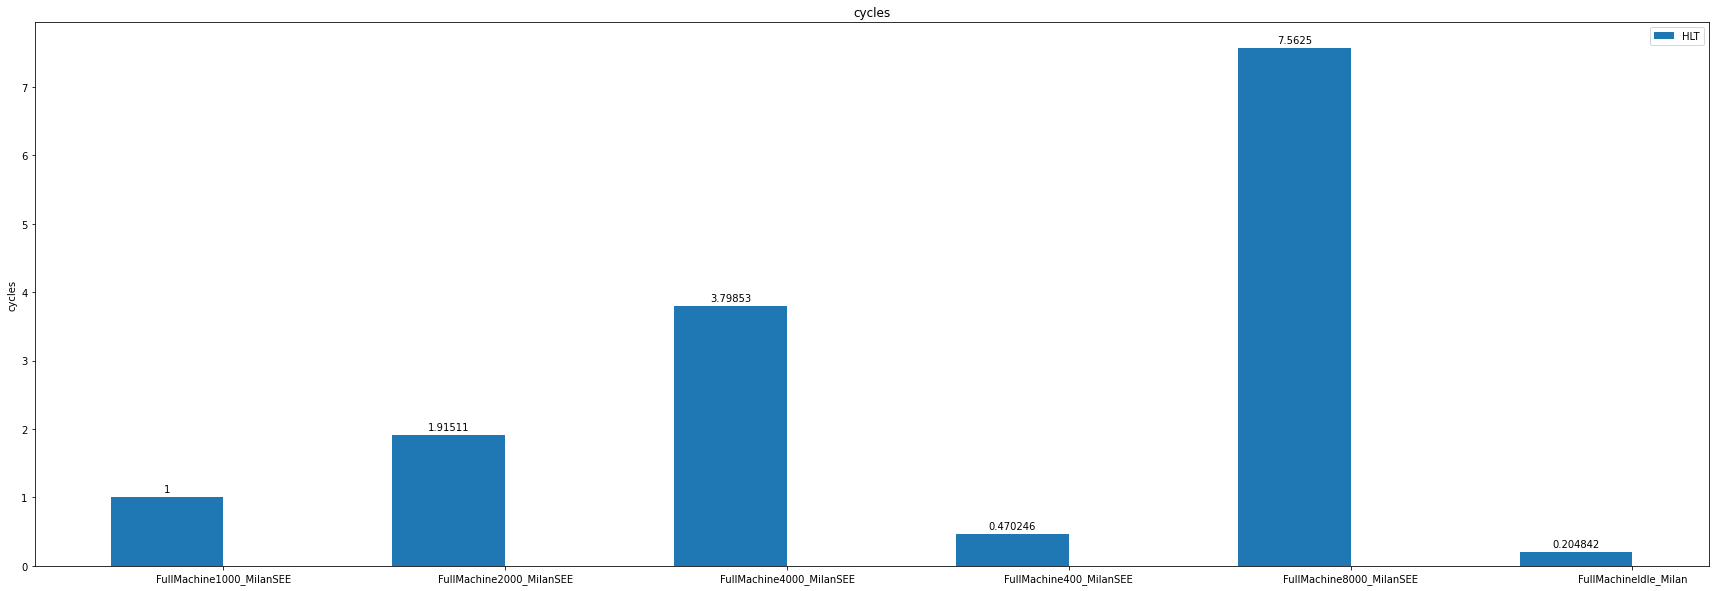

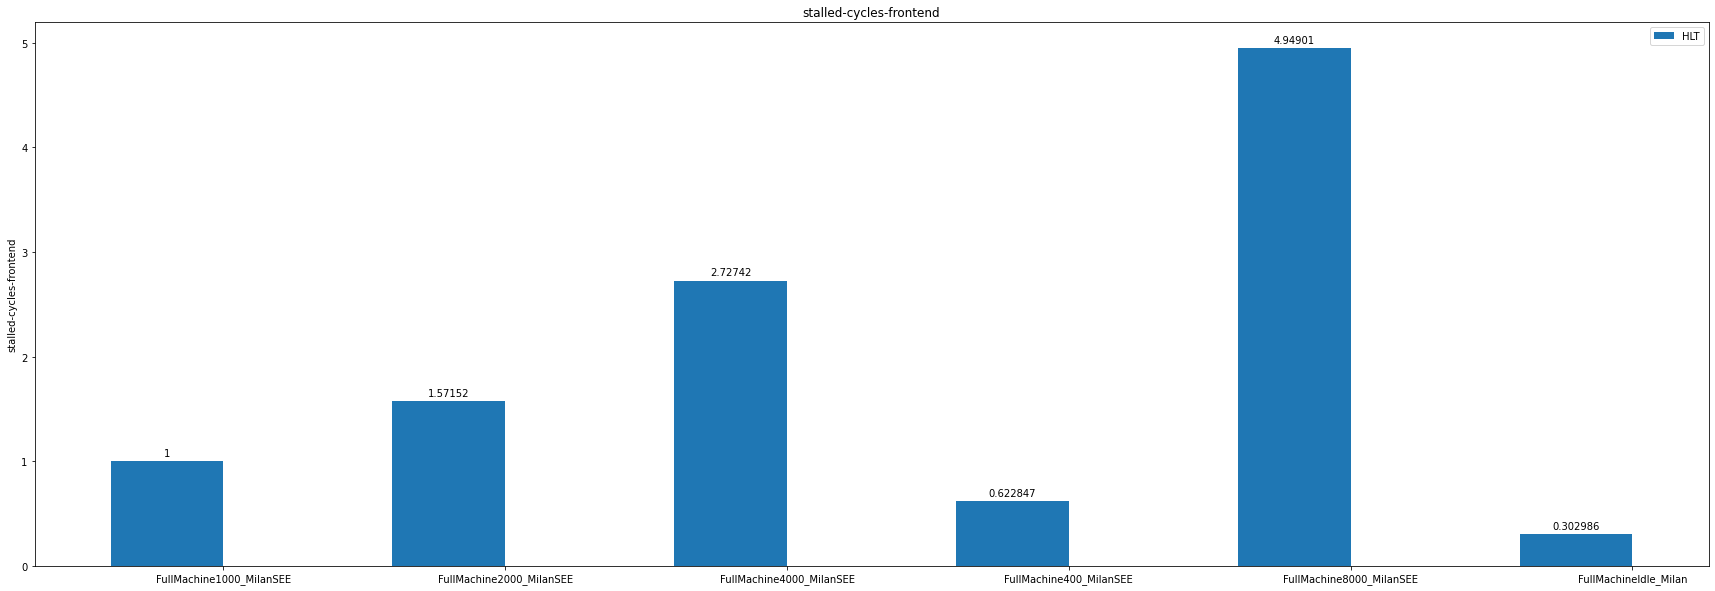

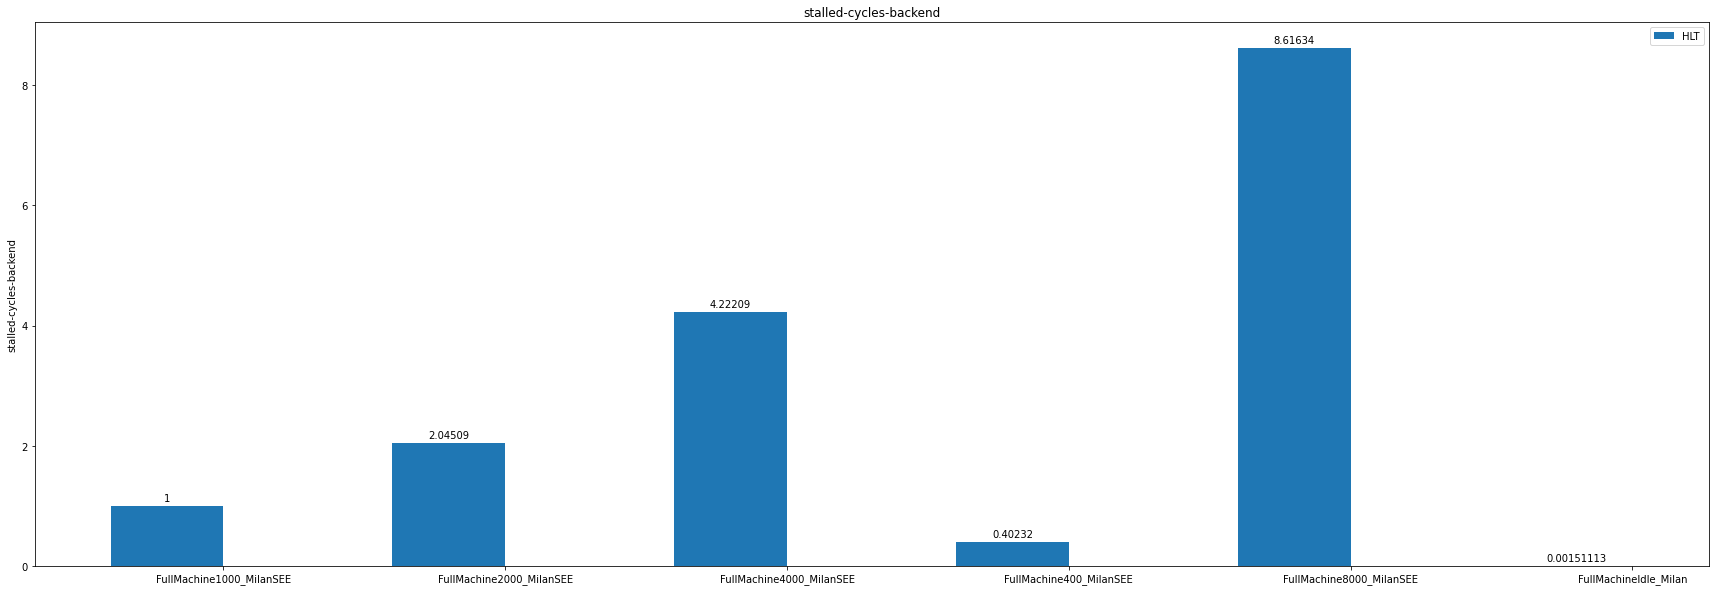

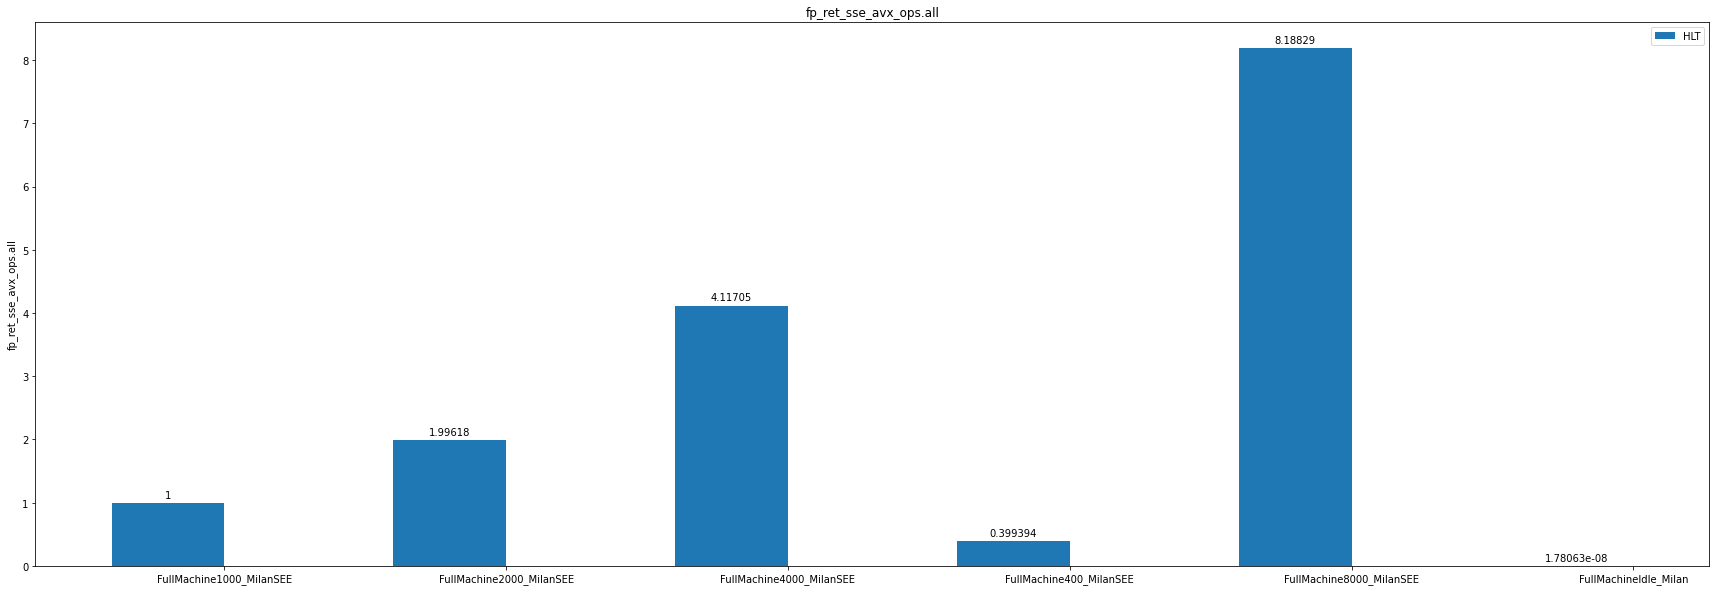

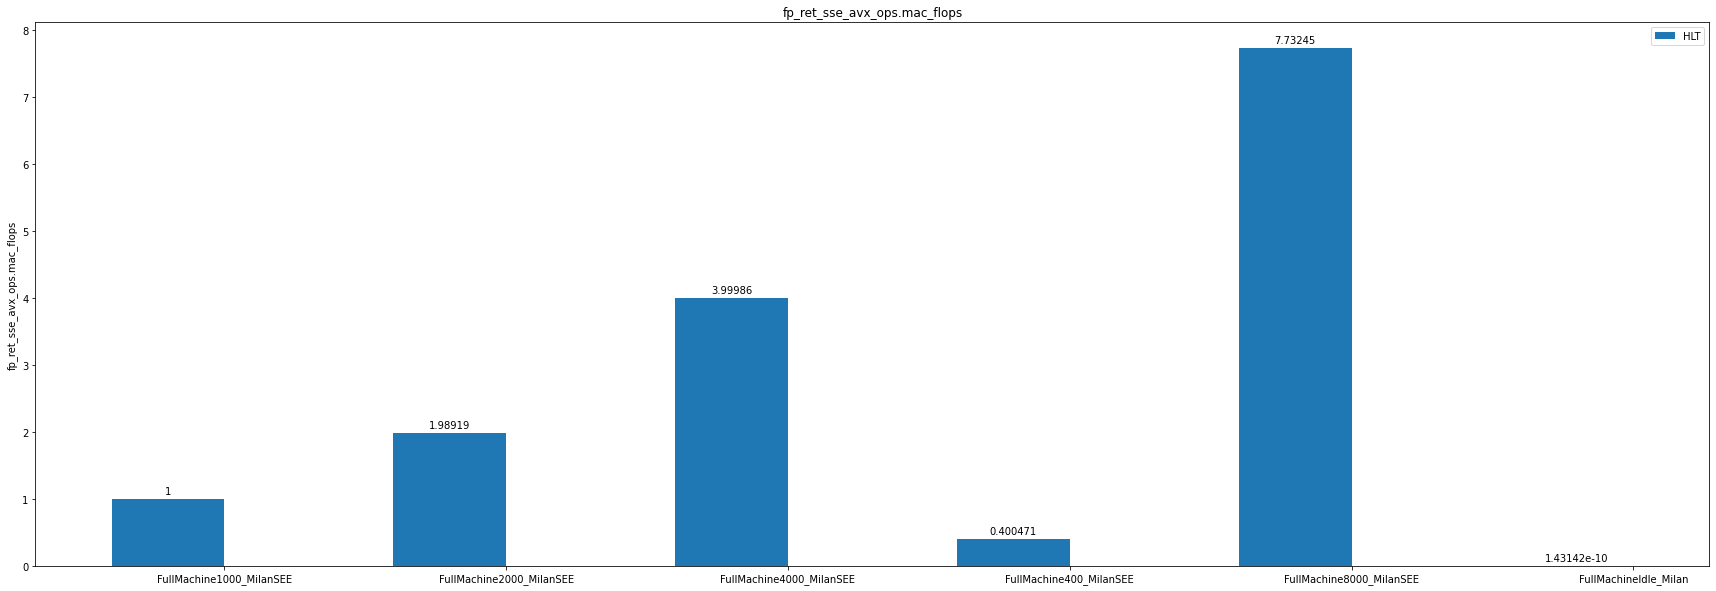

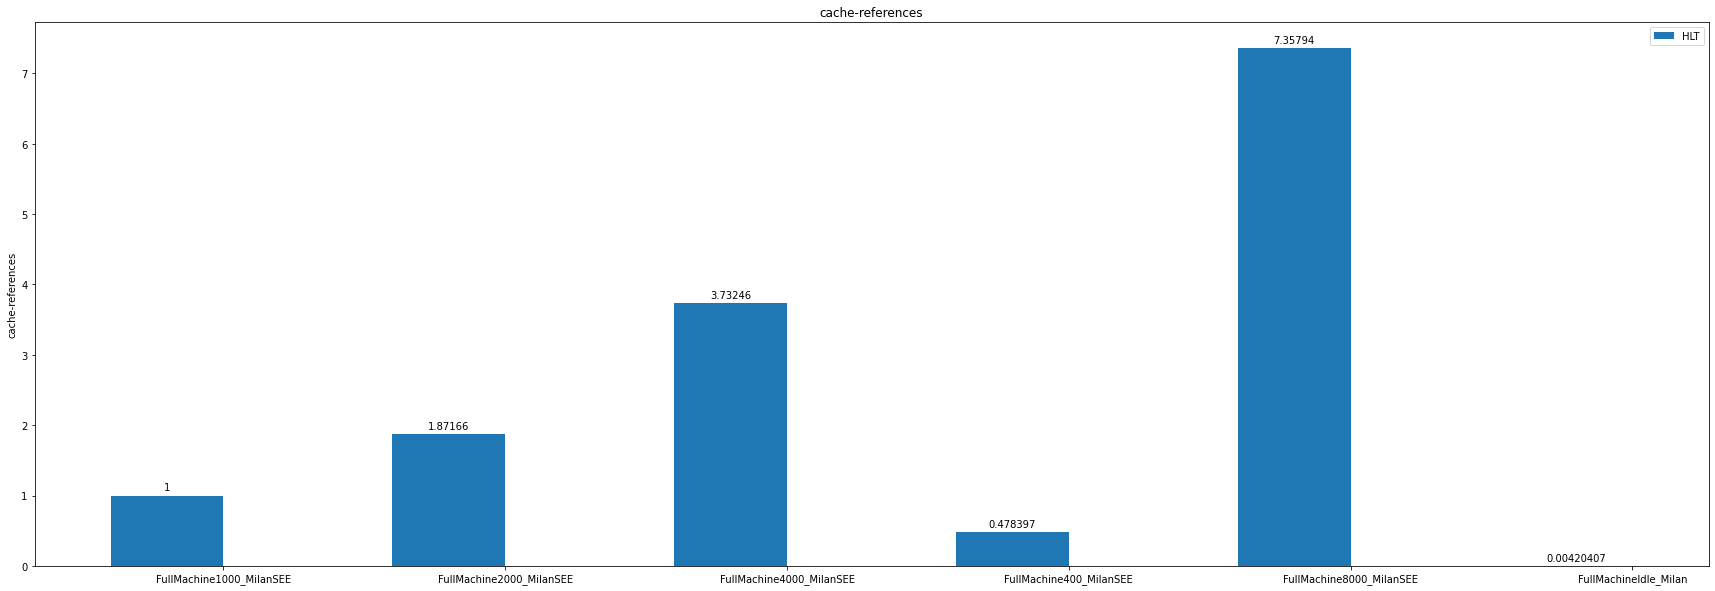

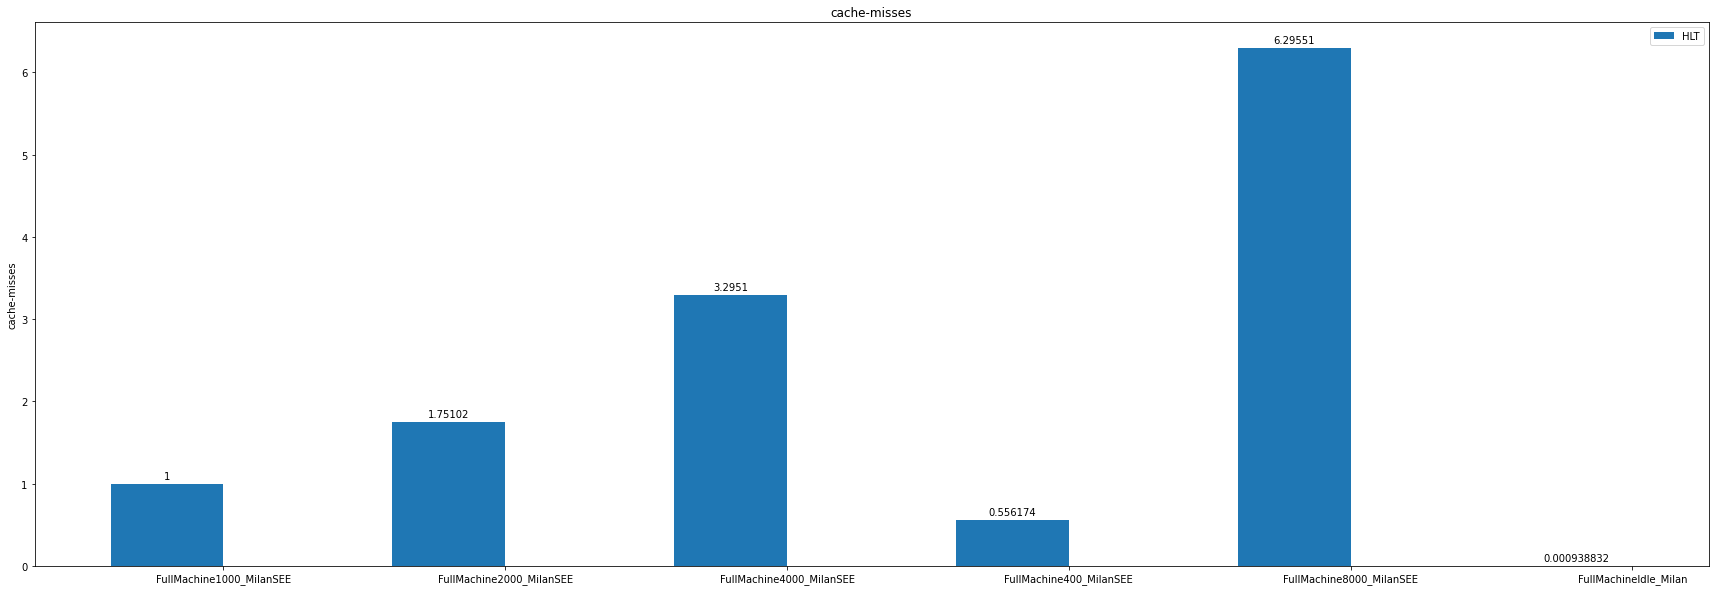

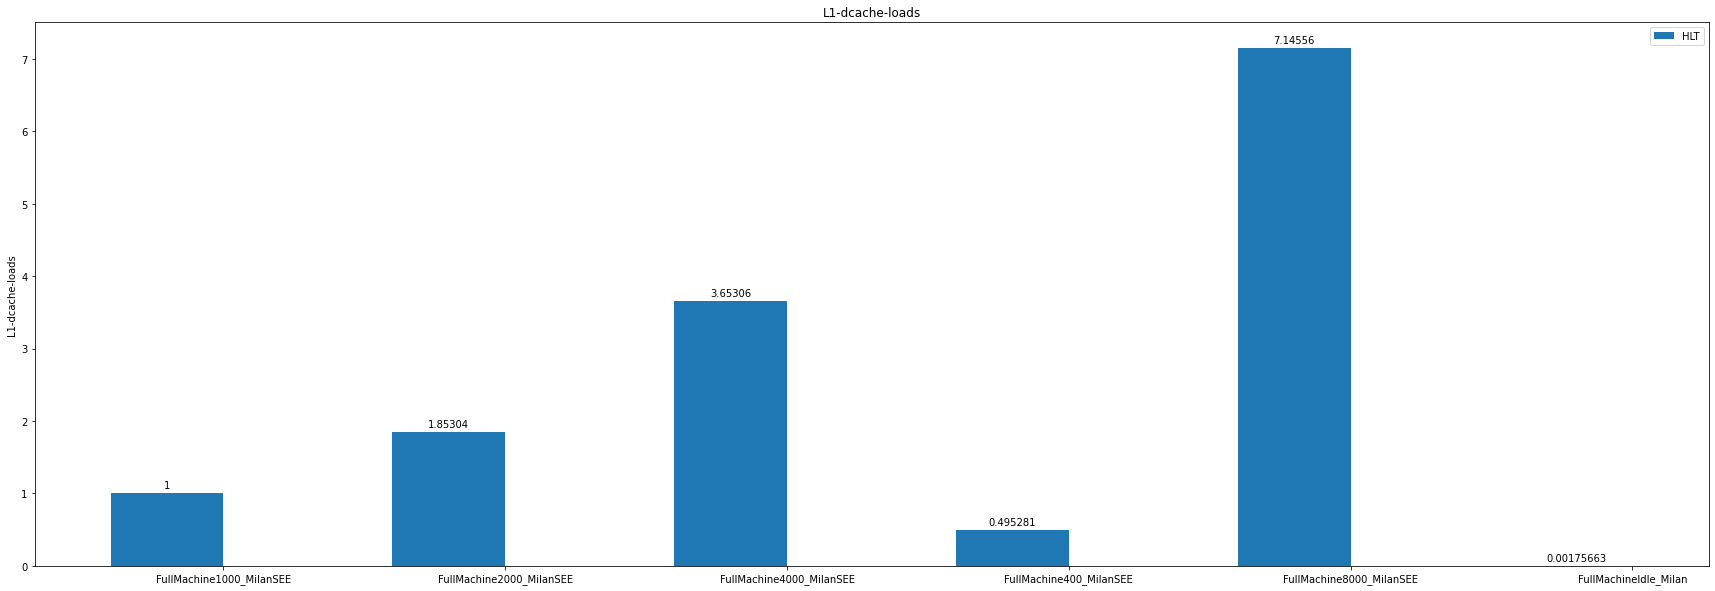

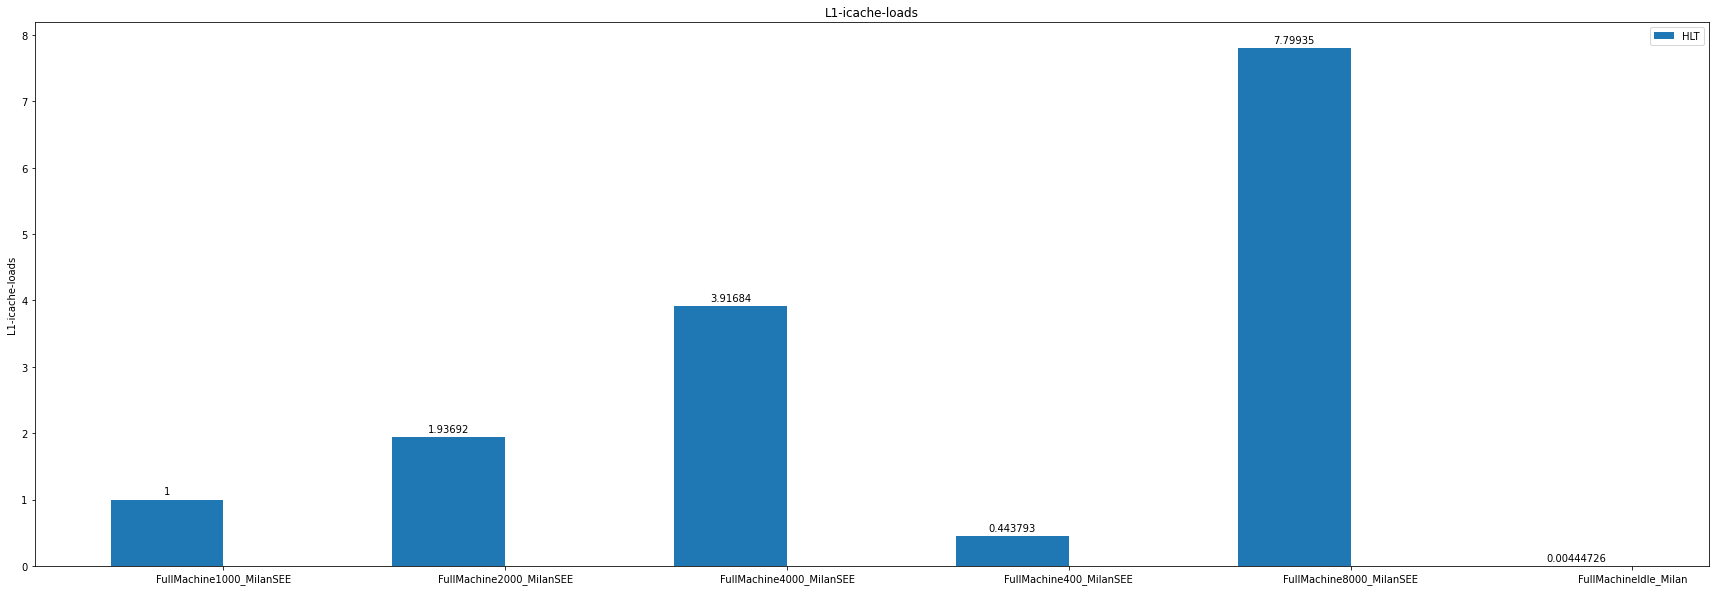

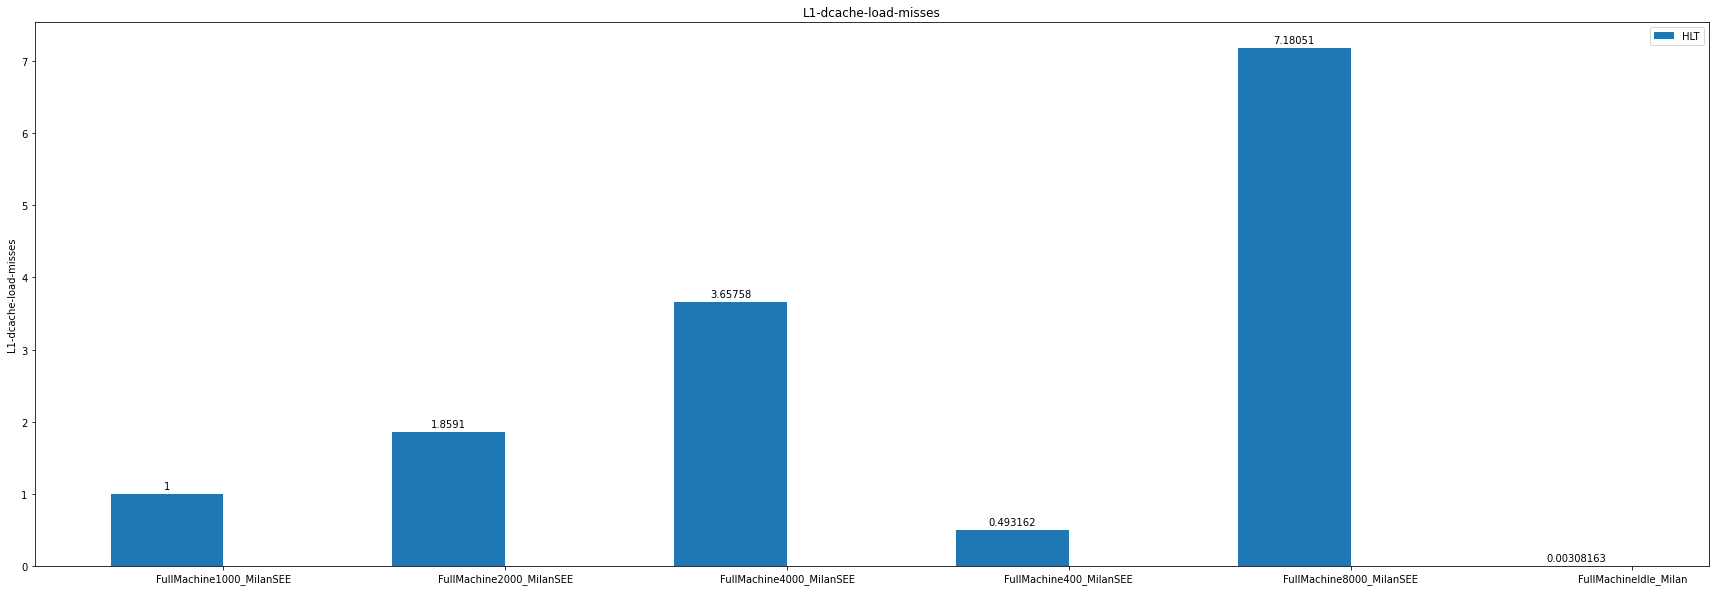

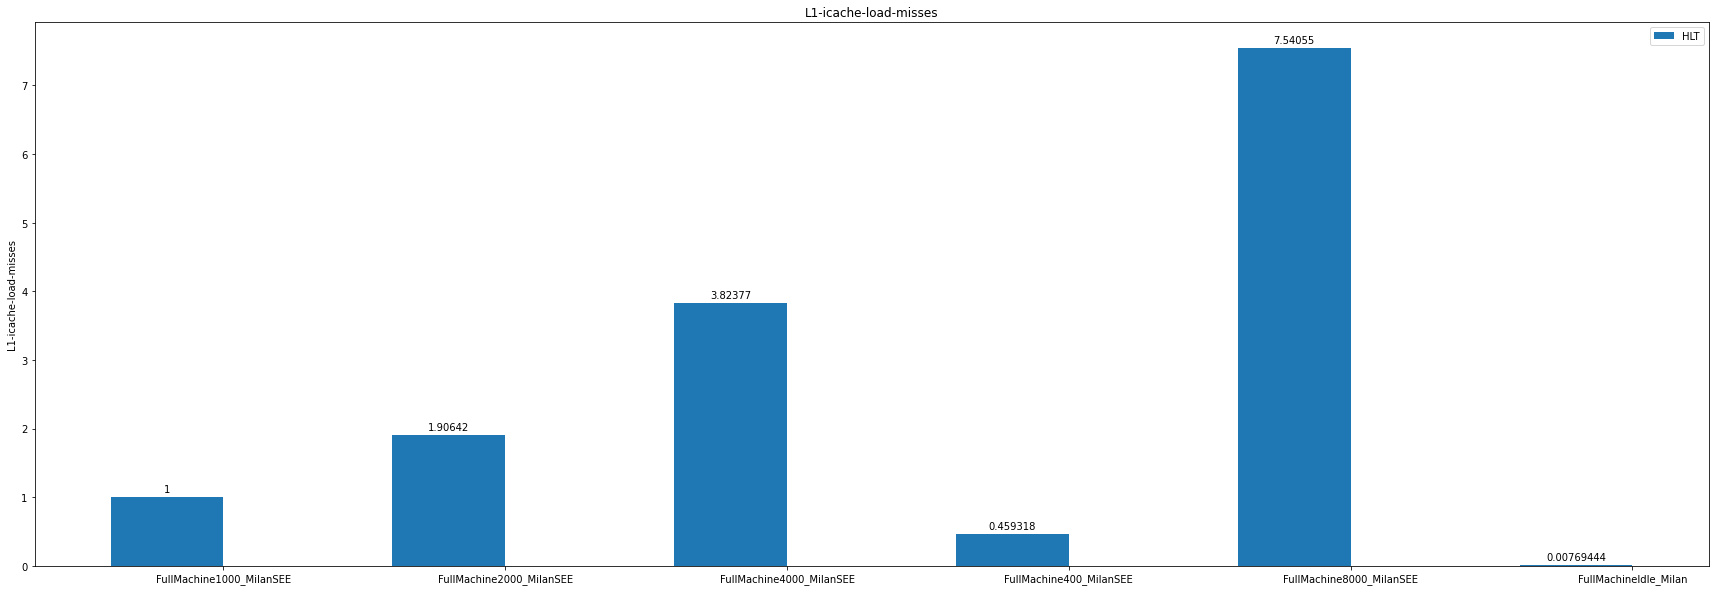

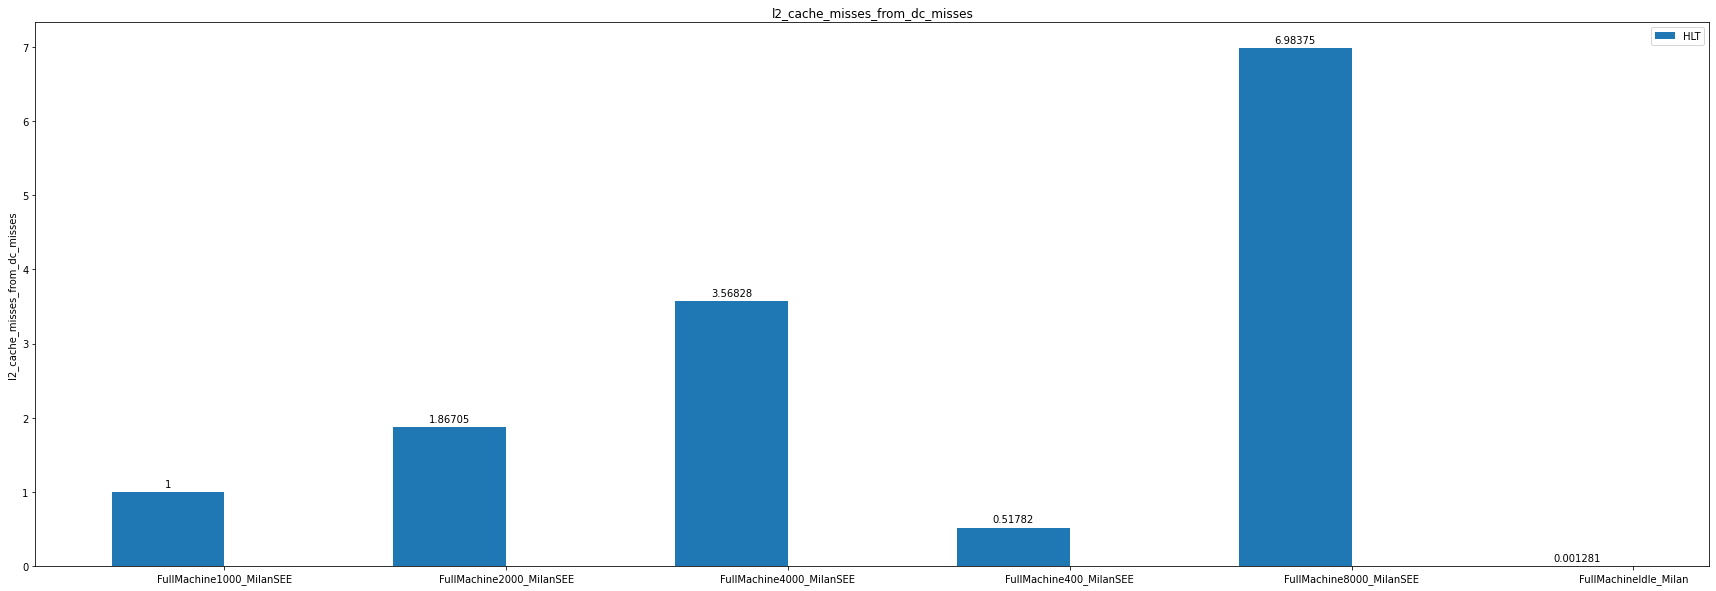

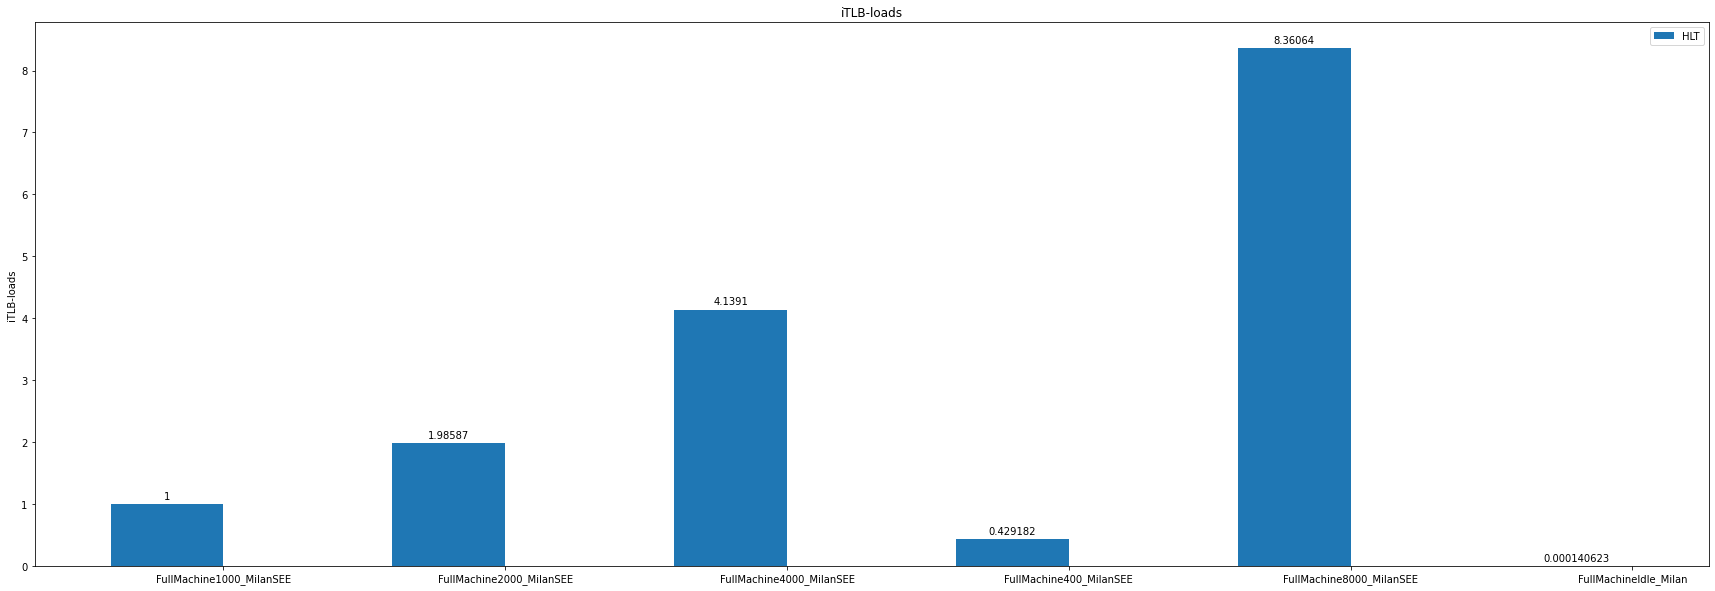

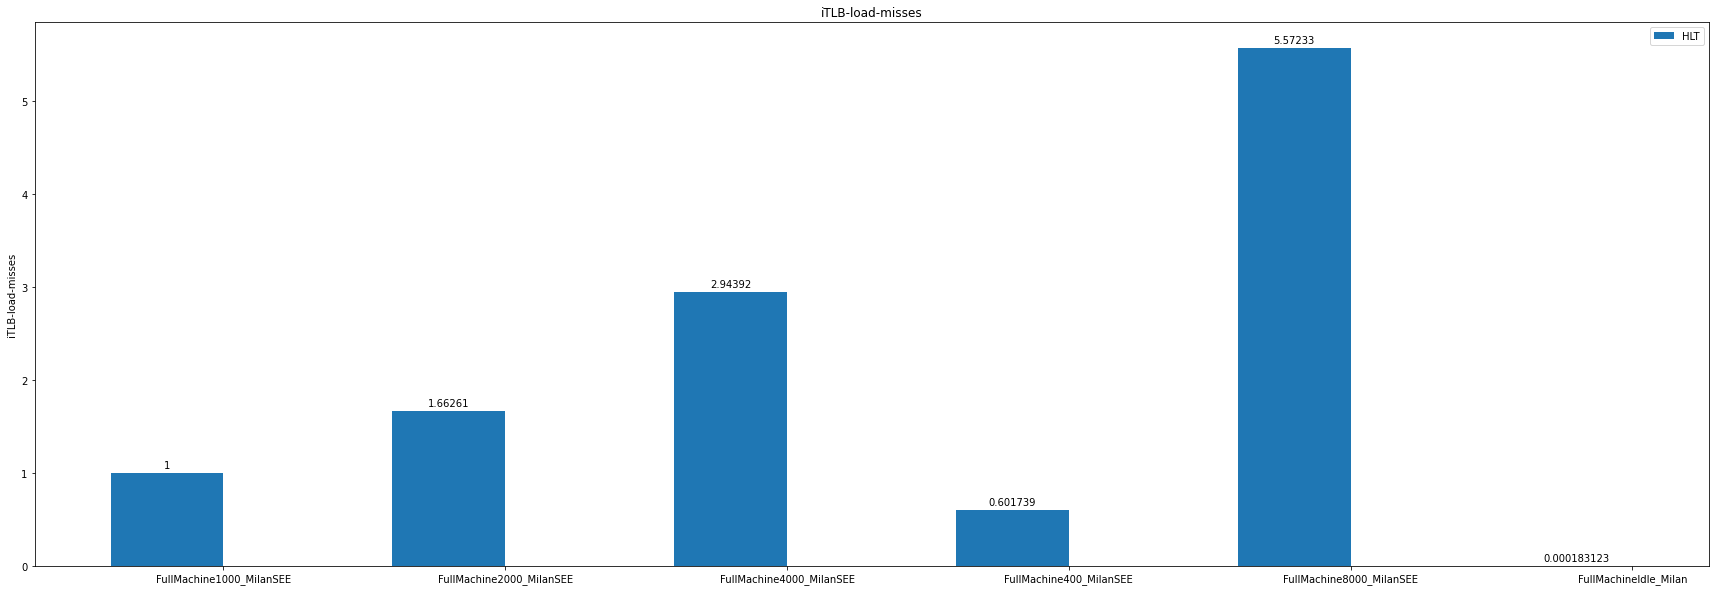

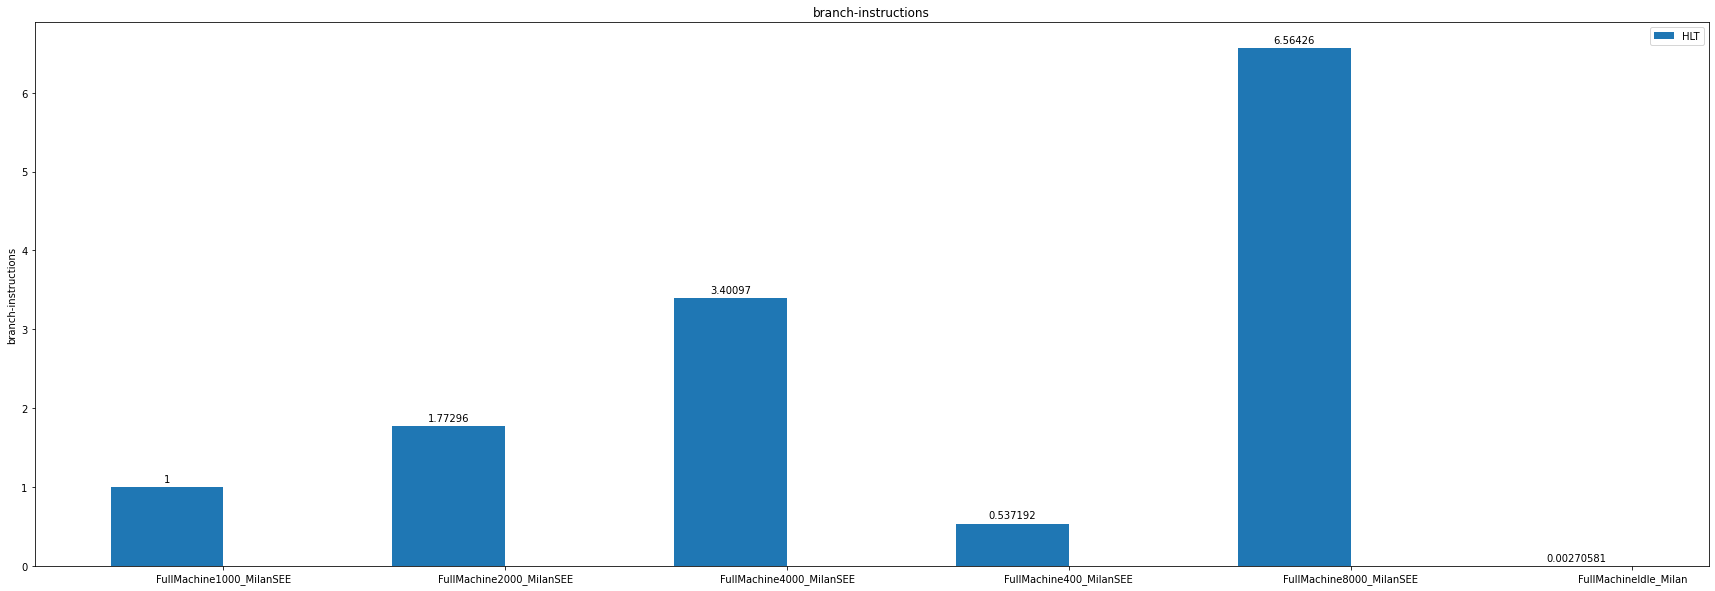

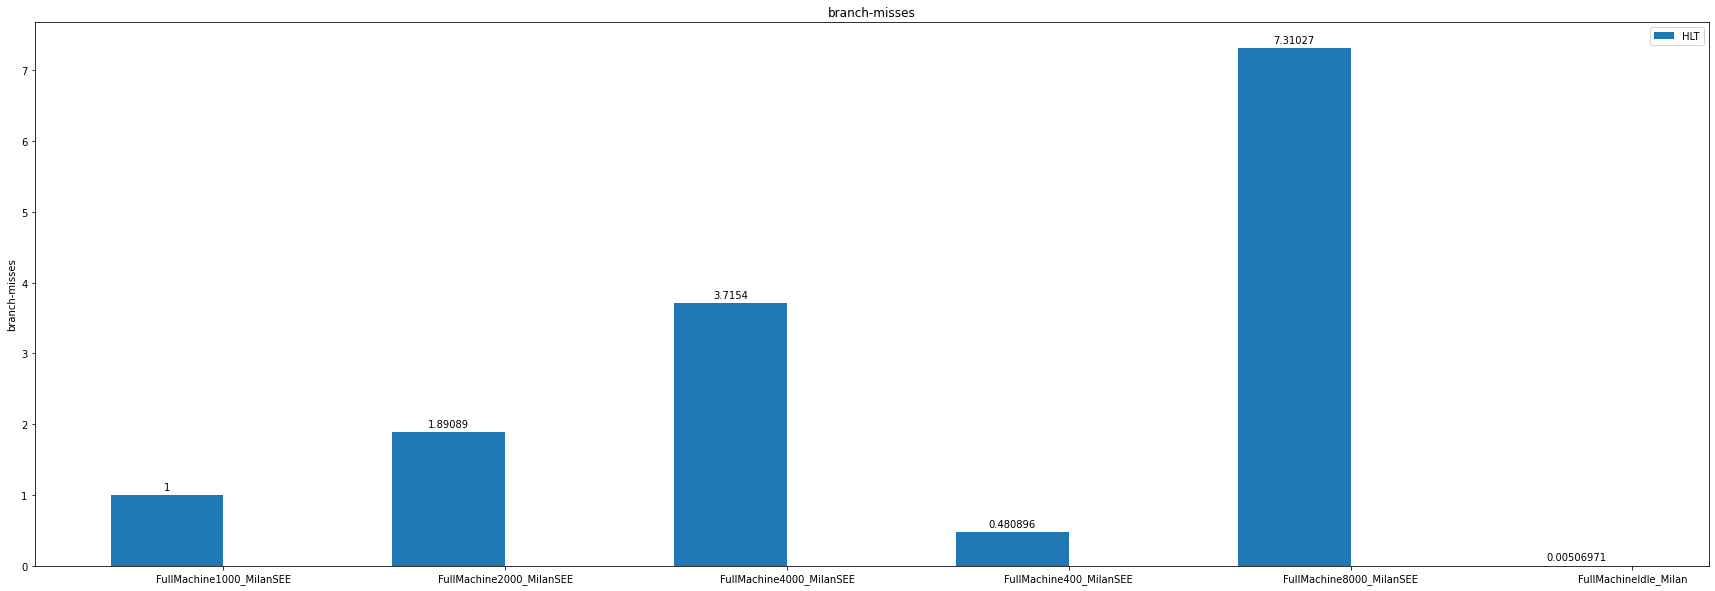

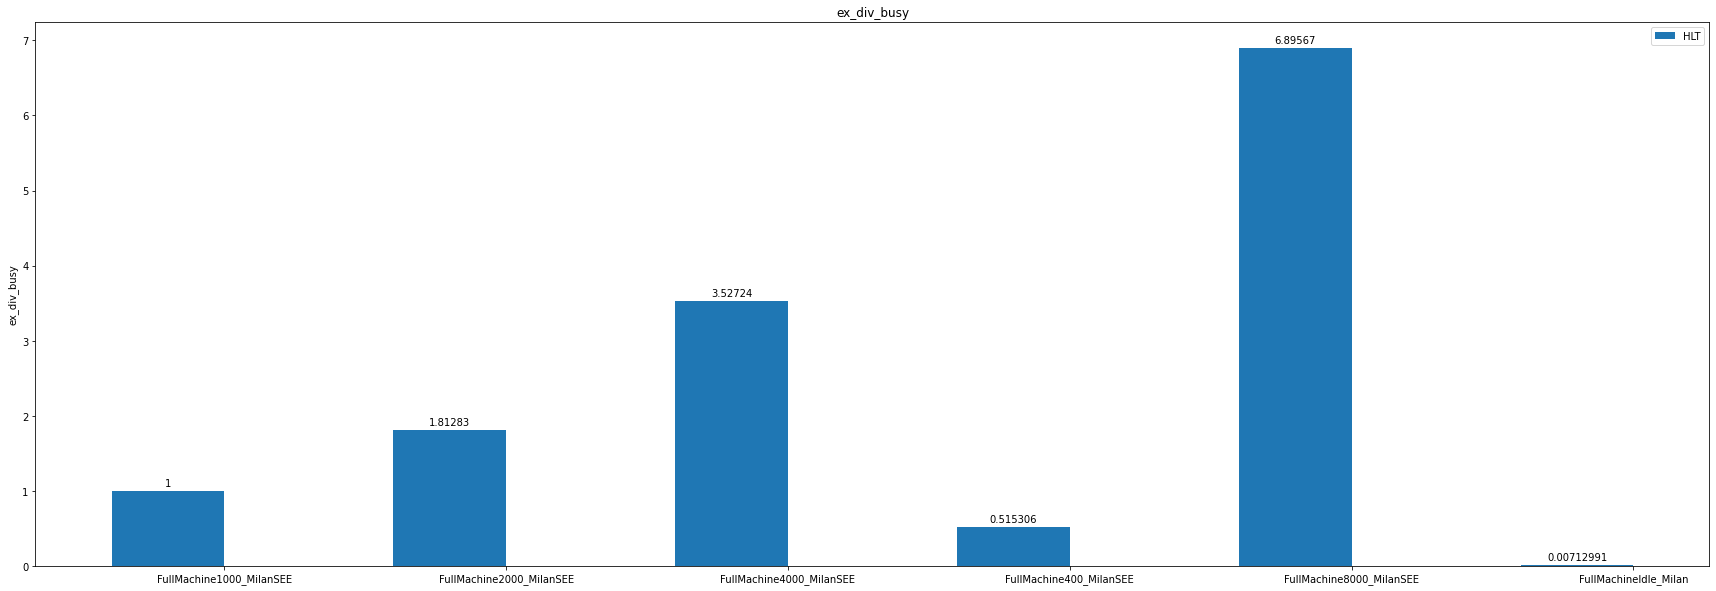

In [139]:
iden = ''
#plotOne('duration',3)
plotOne('wall-clock-ns',3)
plotOne('wall-clock-ns',2)
plotOne('cycles',2)
plotOne('stalled-cycles-frontend',0)
plotOne('stalled-cycles-backend',0)
plotOne('instructions',0)
iden = 'FullMachine1000_MilanSEE'
plotOne('wall-clock-ns',3)
plotOne('instructions',3)
plotOne('cycles',3)
plotOne('stalled-cycles-frontend',3)
plotOne('stalled-cycles-backend',3)
#plotOne('ex_ret_mmx_fp_instr.sse_instr',3)
plotOne('fp_ret_sse_avx_ops.all',3)
plotOne('fp_ret_sse_avx_ops.mac_flops',3)
#plotOne('all_data_cache_accesses',3)
plotOne('cache-references',3)
plotOne('cache-misses',3)
plotOne('L1-dcache-loads',3)
plotOne('L1-icache-loads',3)
plotOne('L1-dcache-load-misses',3)
plotOne('L1-icache-load-misses',3)
plotOne('l2_cache_misses_from_dc_misses',3)
#plotOne('l3_cache_accesses',3)
#plotOne('l3_misses',3)
plotOne('iTLB-loads',3)
plotOne('iTLB-load-misses',3)
# plotOne('branches',3)
plotOne('branch-instructions',3)
plotOne('branch-misses',3)
plotOne('ex_div_busy',3)